In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import cv2   
import glob
import os
import random 



In [2]:
# ------------------------------------------------------ A ------------------------------------------------------#
def eigenfaces_train(trainset,v):
    #extract eigenvalues and eigenvectors
    #center zero-mean
    X_meaned = np.array(trainset) - np.mean(np.array(trainset) , axis = 0)
    
    #create covariance matrix
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    #calculate Eigens
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #select top v-eigens
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    
    eigenvectors = eigenvector_subset = sorted_eigenvectors[:,0:v]
    
    return eigenvectors.T,np.mean(np.array(trainset) , axis = 0)


#read images and labels
def read_images(dir="./inputs/P6/LFW/train/*.jpg"):
    train_set = []
    train_labels = []
    images = list(glob.glob(dir))
    np.random.shuffle(images)
    for img in images:
        #plt.imshow(cv2.imread(img,0))
        #plt.show()
        img_arr= np.resize(cv2.imread(img,0),(4800,))
        train_set.append(img_arr) 
        tmp = "".join(list(os.path.splitext(os.path.basename(img))[0].split("_"))[0:2])
        train_labels.append(tmp)
    return train_set,train_labels

train_set,train_labels = read_images()
eigenvectors,mean_image = eigenfaces_train(train_set,50)

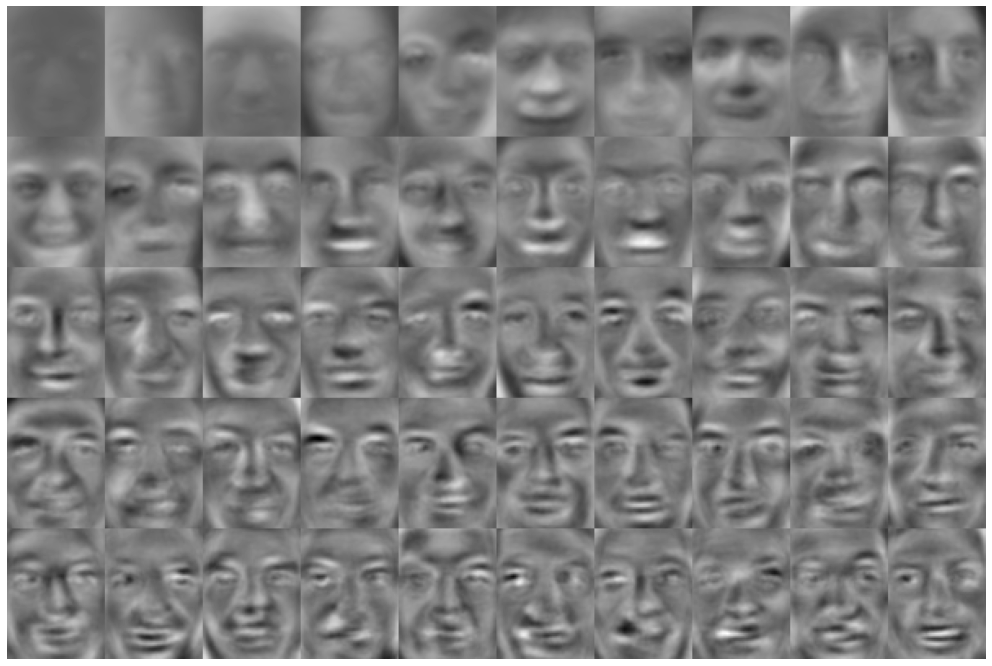

In [3]:
# ------------------------------------------------------ B ------------------------------------------------------#
#print multi images with each other
def concat_tile(im_list_2d):
    return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])

# printing top 50 eigenvectors
report_images = []
row_images = []
for index in range(50):
    row_images.append(np.resize(eigenvectors[index],(80,60)))
    if (index+1)%10==0:
        report_images.append(np.array(row_images))
        row_images = []

report_images = np.array(report_images) 
im_tile = concat_tile(np.array(report_images))
plt.axis('off')
plt.imshow(im_tile,cmap='gray')
plt.show() 


Un/Compressing Sample #1(No. in dataset:571)
Un/Compressing Sample #2(No. in dataset:479)
Un/Compressing Sample #3(No. in dataset:63)
Un/Compressing Sample #4(No. in dataset:429)
Un/Compressing Sample #5(No. in dataset:457)
Un/Compressing Sample #6(No. in dataset:244)
Un/Compressing Sample #7(No. in dataset:19)
Un/Compressing Sample #8(No. in dataset:717)
Un/Compressing Sample #9(No. in dataset:795)
Un/Compressing Sample #10(No. in dataset:44)


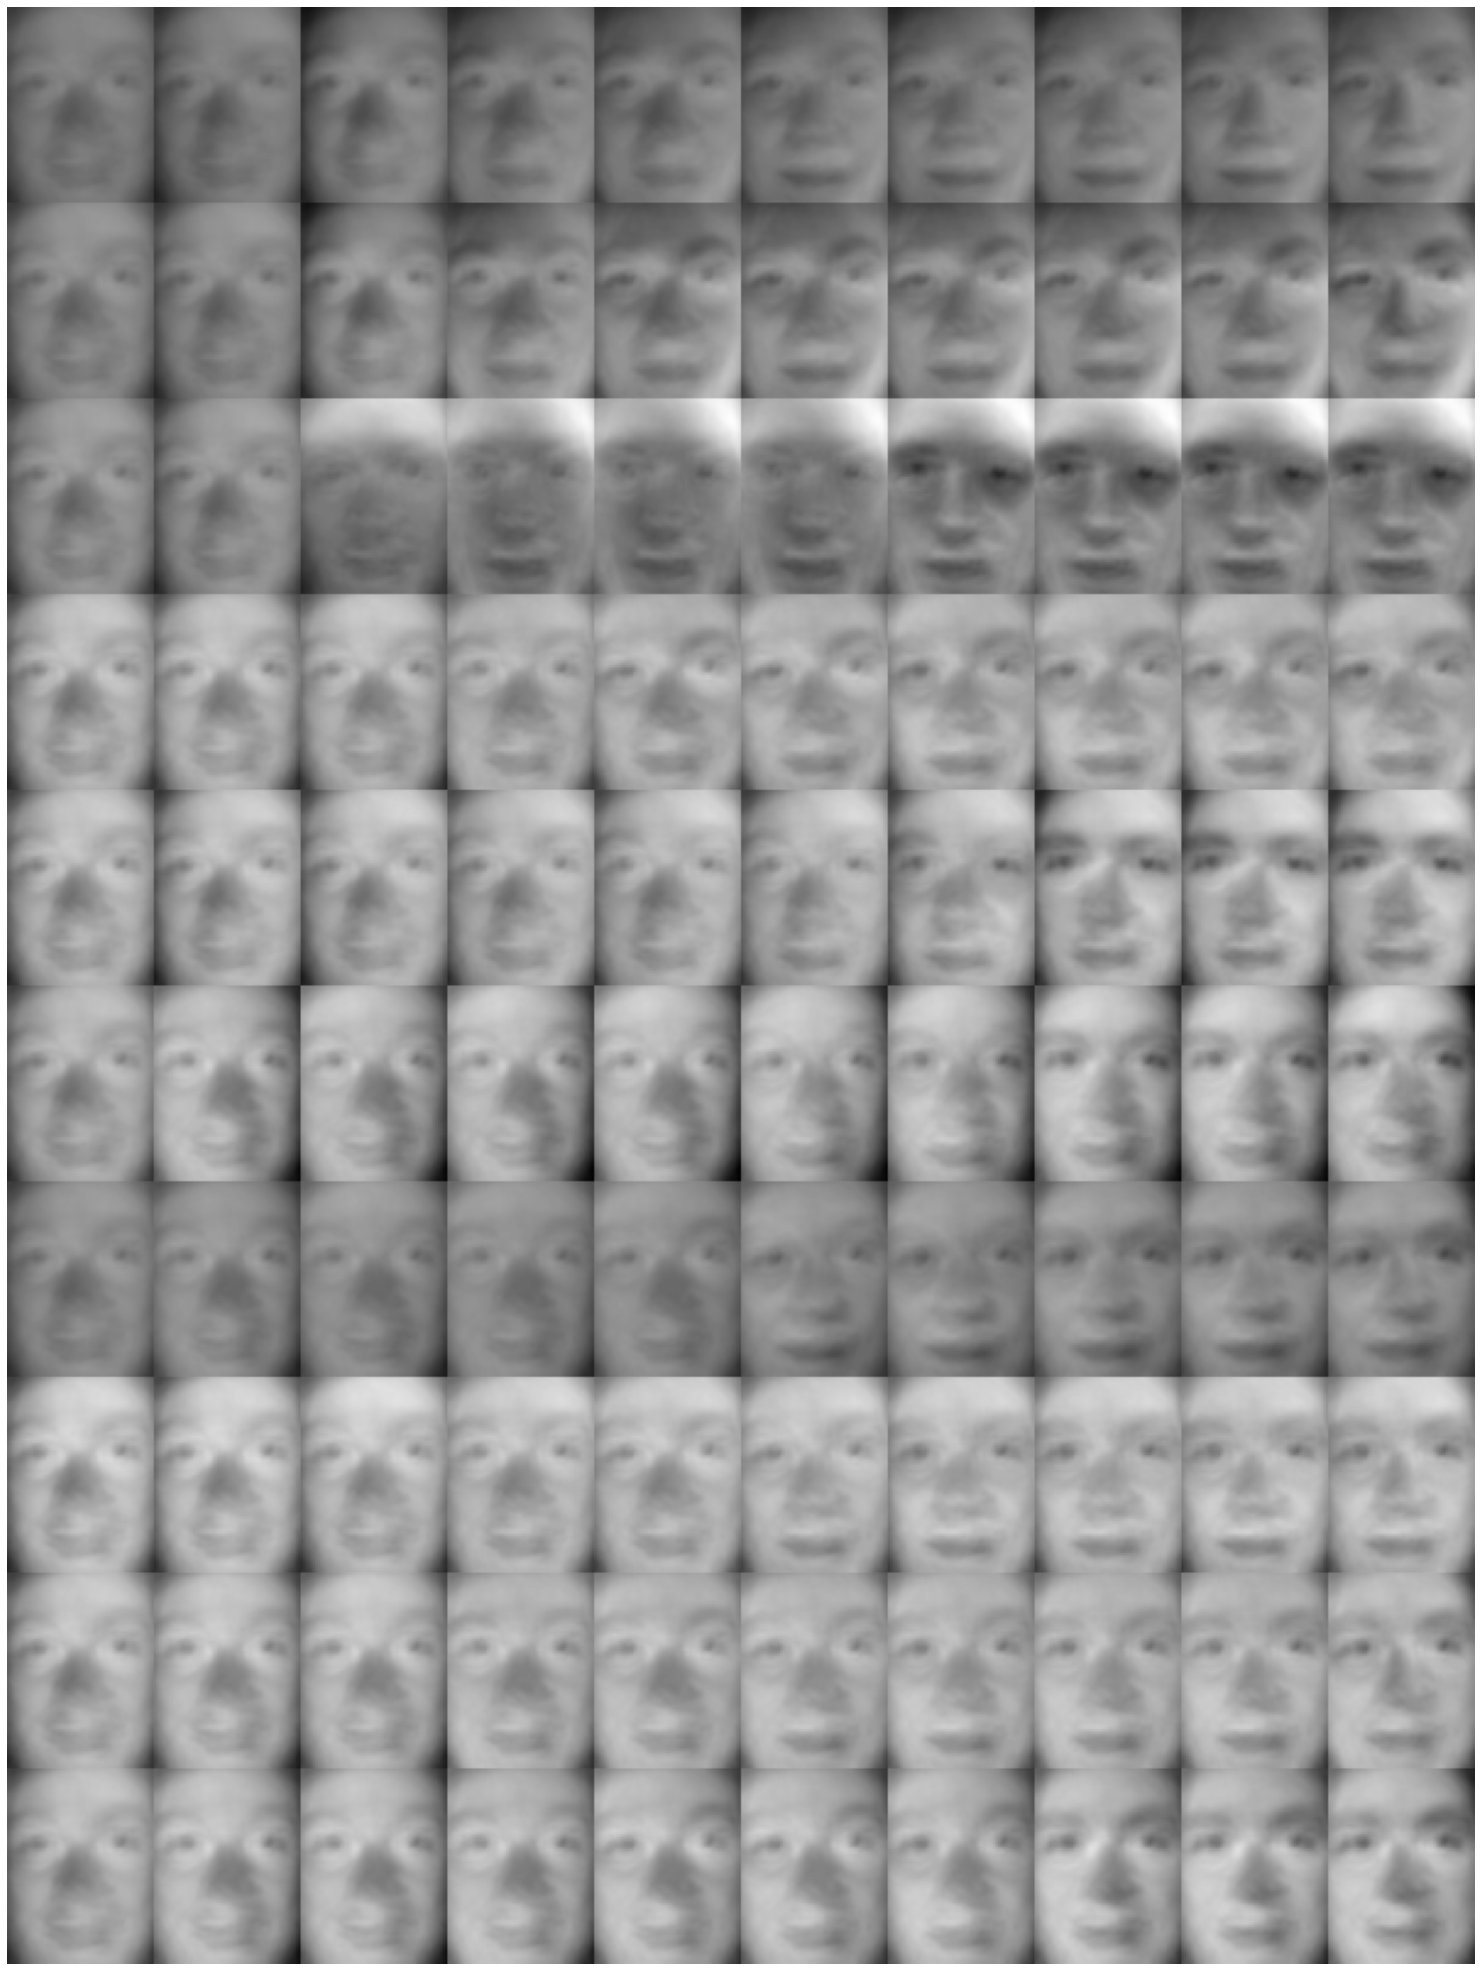

In [4]:
# ------------------------------------------------------ C ------------------------------------------------------#
plt.rcParams["figure.figsize"] = (60,36)
SAMPLE = 10
V = list(range(1,11))
# select random images
smaples = random.sample(range(0, len(train_labels)), SAMPLE)



index=0
report_images = []
row_images = []
for i in range(SAMPLE):
    print("Un/Compressing Sample #{0}(No. in dataset:{1})".format(i+1,smaples[i]))
    for j in V:  
        # compress images
        tmp = np.dot(eigenvectors[:j],np.resize(train_set[smaples[i]],(4800,1)))
        
        #uncompress images
        tmp = np.dot(eigenvectors[:j].T,tmp)  
        
        #store result
        row_images.append(np.resize(tmp,(80,60)))

    report_images.append(np.array(row_images))
    row_images = []
 
report_images = np.array(report_images) 
im_tile = concat_tile(np.array(report_images))
plt.axis('off')
plt.imshow(im_tile,cmap='gray')
plt.show() 

In [5]:
# ------------------------------------------------------ D ------------------------------------------------------#
eigenvectors,mean_image = eigenfaces_train(train_set,50)

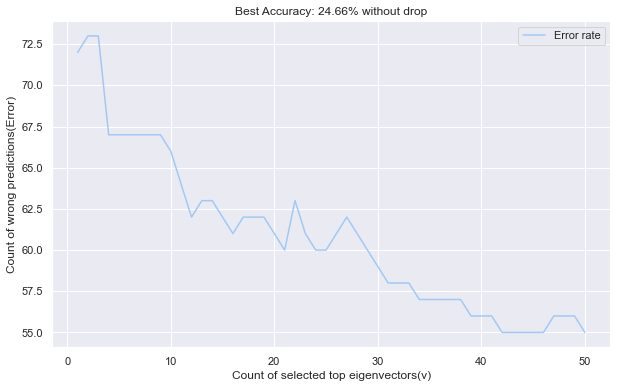

In [6]:
def eigenfaces_test(trainset,trainlabels,testset,W,mu,v,testlabels,drop=0):
    transformed_train = []
    #transform trainset images eigenvector spaces
    for item in trainset:
        tmp = np.dot(W[drop:drop+v],np.resize(item,(4800,)))
        transformed_train.append(tmp)
        
    #transform testset images eigenvector spaces
    transformed_test = []
    for item in testset:
        tmp = np.dot(W[drop:drop+v],np.resize(item,(4800,)))
        transformed_test.append(tmp)
        
    # KNN Classifier with one neighbor and L2 distance(p=2)
    knn = KNeighborsClassifier(n_neighbors=1,p=2)
    knn.fit(transformed_train,trainlabels)
    
    #make prediction
    pred = knn.predict(transformed_test)
    
    Calculates Errors
    Error = 0
    for index in range(len(testlabels)):
        if testlabels[index] != pred[index] :
            Error += 1
            #print(testlabels[index][:4] , pred[index][:4])
    return Error
        
# read testset
test_set,test_labels = read_images("./inputs/P6/LFW/test/*.jpg")

# calculate Error for V=1,...,50
result = []
for i in range(1,51):
    result.append(eigenfaces_test(train_set,train_labels,test_set,eigenvectors,mean_image,i,test_labels))

#plotting result
plt.rcParams["figure.figsize"] = (10,6)
sns.set_theme(style="darkgrid", palette="pastel")
plt.plot(range(1,51),result,label="Error rate")
plt.ylabel("Count of wrong predictions(Error)")
plt.xlabel("Count of selected top eigenvectors(v)")
plt.title("Best Accuracy: {0}% without drop".format(round((len(test_labels)-min(result))/len(test_labels)*100,2)))
plt.legend()
plt.show()

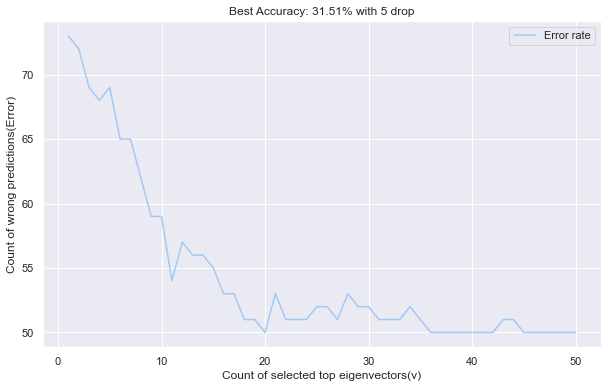

In [7]:
# ------------------------------------------------------ E ------------------------------------------------------#
# calculate Error for V=1,...,50
result = []
for i in range(1,51):
    result.append(eigenfaces_test(train_set,train_labels,test_set,eigenvectors,mean_image,i,test_labels,5)) # drop 5

#plotting result    
plt.rcParams["figure.figsize"] = (10,6)
sns.set_theme(style="darkgrid", palette="pastel")
plt.plot(range(1,51),result,label="Error rate")
plt.ylabel("Count of wrong predictions(Error)")
plt.xlabel("Count of selected top eigenvectors(v)")
plt.title("Best Accuracy: {0}% with 5 drop".format(round((len(test_labels)-min(result))/len(test_labels)*100,2)))
plt.legend()
plt.show()